In [8]:
import os
import gc
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from skimage import color
from keras import layers
import keras.backend as K
import tensorflow as tf
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization, Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.applications.imagenet_utils import preprocess_input
from tqdm import tqdm
import cv2 as cv
from PIL import Image
%matplotlib inline

In [9]:
train = 'E:\\SELVA\\NEXON TECH\\PYTHON PROJECTS\\railway\\RAILWAY DATASET\\Train'
val = 'E:\\SELVA\\NEXON TECH\\PYTHON PROJECTS\\railway\\RAILWAY DATASET\\Validiation'
test = 'E:\\SELVA\\NEXON TECH\\PYTHON PROJECTS\\railway\\RAILWAY DATASET\\Test'

In [10]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
picture_size=128
folder_path = "E:\\SELVA\\NEXON TECH\\PYTHON PROJECTS\\railway\\RAILWAY DATASET\\"
print(os.listdir(folder_path))

['Test', 'Train', 'Validiation']


In [11]:
path_data = 'E:\\SELVA\\NEXON TECH\\PYTHON PROJECTS\\railway\\RAILWAY DATASET\\Train\\'
print(os.listdir(path_data))

['Defective', 'Non Defective']


In [12]:
batch_size=32

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train,
    seed=123,
    shuffle=True,
    image_size=(150,150),
    batch_size=batch_size 
)

Found 980 files belonging to 2 classes.


In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    seed=123,
    shuffle=True,
    image_size=(150,150),
    batch_size=batch_size
)

Found 280 files belonging to 2 classes.


In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test,
    seed=123,
    shuffle=True,
    image_size=(150,150),
    batch_size=batch_size
)

Found 140 files belonging to 2 classes.


In [16]:
train_defective_path = os.path.join(train, 'Defective')
train_undefective_path = os.path.join(train, 'Non Defective')
val_defective_path = os.path.join(val, 'Defective')
val_undefective_path = os.path.join(val, 'Non Defective')
test_defective_path = os.path.join(test, 'Defective')
test_undefective_path = os.path.join(test, 'Non Defective')  


In [17]:
def preprocessing_df(df_path):
    df = pd.DataFrame(os.listdir(df_path), columns=["filename"])
    df['path'] = df.filename.apply(lambda x: df_path + '/'+ x)
    df['width'] =  df.path.apply(lambda x: Image.open(x).size[0])
    df['height'] =  df.path.apply(lambda x: Image.open(x).size[1])
    df['dimension'] = df.width*df.height
    return df

In [18]:
train_defective = preprocessing_df(train_defective_path)
train_undefective = preprocessing_df(train_undefective_path)

val_defective = preprocessing_df(val_defective_path)
val_undefective = preprocessing_df(val_undefective_path)

test_defective = preprocessing_df(test_defective_path)
test_undefective = preprocessing_df(test_undefective_path)

In [19]:
print('Train samples defective: ', len(train_defective))
print('Val samples defective: ', len(val_defective))
print('Test samples defective: ', len(test_defective))
print()
print('Train samples undefective: ', len(train_undefective))
print('Val samples undefective: ', len(val_undefective))
print('Test samples undefective: ', len(test_undefective))

Train samples defective:  490
Val samples defective:  140
Test samples defective:  70

Train samples undefective:  490
Val samples undefective:  140
Test samples undefective:  70


In [20]:
defective=pd.concat([train_defective,test_defective,val_defective], axis=0)
undefective=pd.concat([train_undefective,test_undefective,val_undefective], axis=0)

In [21]:
class_names=train_ds.class_names

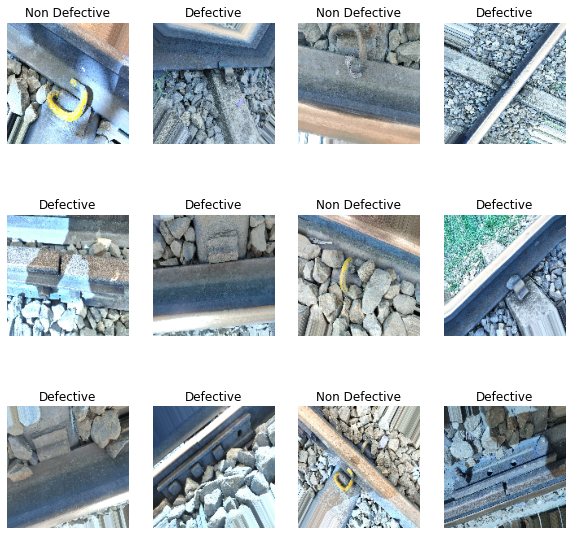

In [22]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

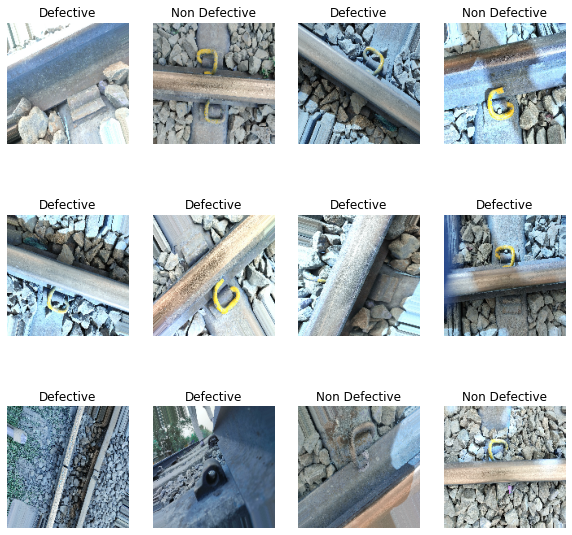

In [23]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(2):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [24]:
if len(defective) == len(undefective):
    print("Data is Balance")

Data is Balance


In [25]:
gc.collect()

15

In [26]:
class CFG:
    sampleFrac = 0.5 
def is_grey_scale(img):
    rgbImage = img.convert("RGB")
    # A RGB image is Grey when R=G=B 
    w,h = rgbImage.size
    for i in range(w):
        for j in range(h):
            r,g,b = rgbImage.getpixel((i,j))
            if r != g != b: return False
    return True
# Intensity
def get_rgb_men(row):
    img = cv.imread(row.path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return np.sum(img[:,:,0]), np.sum(img[:,:,1]), np.sum(img[:,:,2])
def display(df):
    samples = np.random.randint(len(df), size=32)
    plt.figure(figsize=(15,12))
    df = df.loc[samples,:]
    for idx,img_dir in enumerate(df.path):
        plt.subplot(4,8,idx+1)
        img = Image.open(img_dir)
        img.resize((224,224))
        plt.imshow(img)
        plt.axis('off')
        plt.title(idx)
    plt.tight_layout()
    plt.show()

In [27]:
isGreyList = [is_grey_scale(Image.open(img)) for img in defective.path.sample(frac=CFG.sampleFrac)]
if np.sum(isGreyList) / len(isGreyList) == 0.0:
    print("Defective Data has no Grey Image")
else:
    print("Defective Data has Grey Image")
del isGreyList

Defective Data has no Grey Image


In [28]:
isGreyList = [is_grey_scale(Image.open(img)) for img in undefective.path.sample(frac=CFG.sampleFrac)]
if np.sum(isGreyList) / len(isGreyList) == 0.0:
    print("Un-Defective Data has no Grey Image")
else:
    print("Un-Defective Data has Grey Image")
del isGreyList

Un-Defective Data has no Grey Image


In [29]:
tqdm.pandas()
defective['R'], defective['G'], defective['B'] = zip(*defective.progress_apply(lambda row: get_rgb_men(row), axis=1))

100%|██████████| 700/700 [03:04<00:00,  3.79it/s]


In [30]:
undefective['R'], undefective['G'], undefective['B'] = zip(*undefective.progress_apply(lambda row: get_rgb_men(row), axis=1) )

100%|██████████| 700/700 [03:05<00:00,  3.77it/s]


In [31]:
def show_color_dist(df, count):
    fig, axr = plt.subplots(count,2,figsize=(15,15))
    if df.empty:
        print("Image internsity of selected color is weak")
        return
    for idx, i in enumerate(np.random.choice(df['path'], count)):
        img = cv.imread(i)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        axr[idx,0].imshow(img)
        axr[idx,0].axis('off')
        axr[idx,1].set_title('R={:.0f}, G={:.0f}, B={:.0f} '.format(np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2]))) 
        x, y = np.histogram(img[:,:,0], bins=255)
        axr[idx,1].bar(y[:-1], x, label='R', alpha=0.8, color='red')
        x, y = np.histogram(img[:,:,1], bins=255)
        axr[idx,1].bar(y[:-1], x, label='G', alpha=0.8, color='green')
        x, y = np.histogram(img[:,:,2], bins=255)
        axr[idx,1].bar(y[:-1], x, label='B', alpha=0.8, color='blue')
        axr[idx,1].legend()
        axr[idx,1].axis('off')

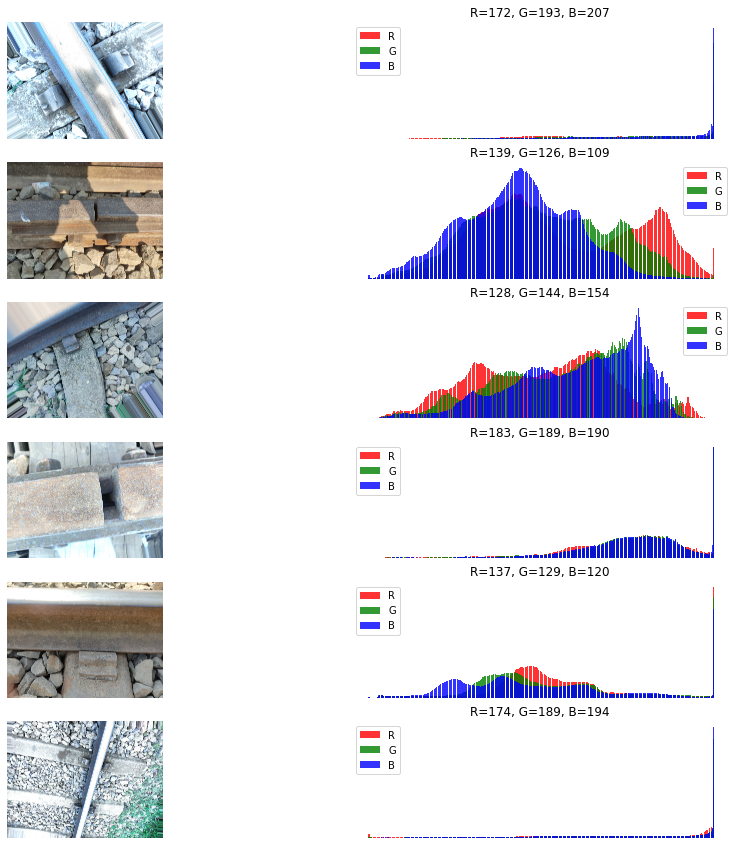

In [32]:
df = defective[((defective['B']*1.05) < defective['R']) & ((defective['G']*1.05) < defective['R'])]
show_color_dist(df, 6)

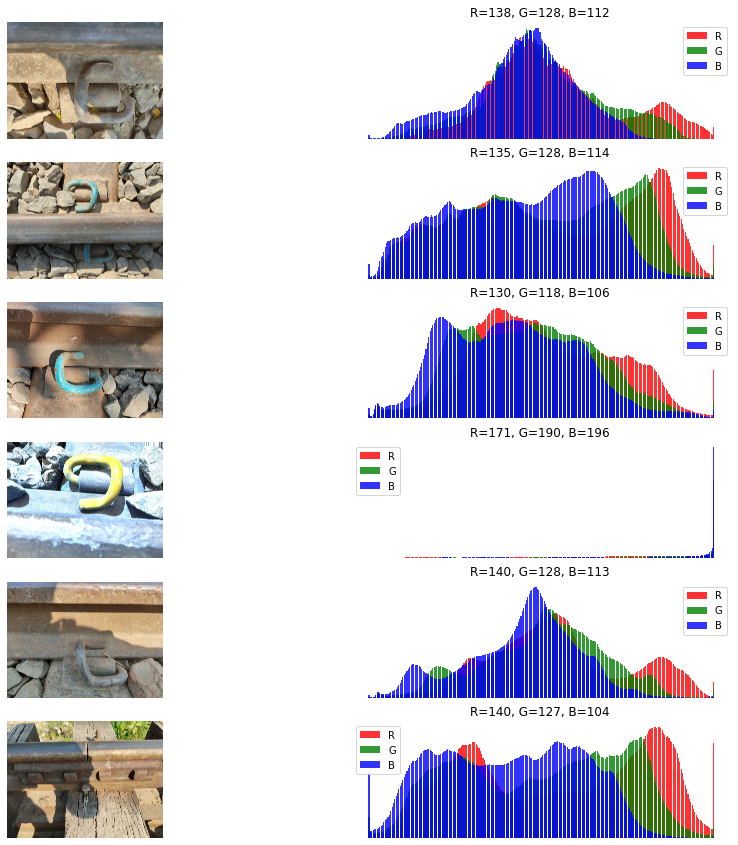

In [33]:
df = undefective[((undefective['B']*1.05) < undefective['R']) & ((undefective['G']*1.05) < undefective['R'])]
show_color_dist(df, 6)

In [34]:
gc.collect()

299592

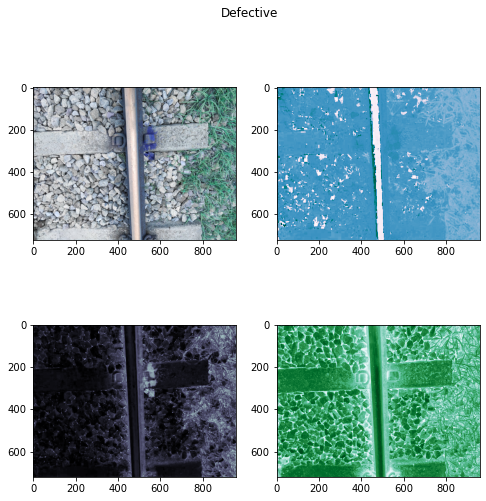

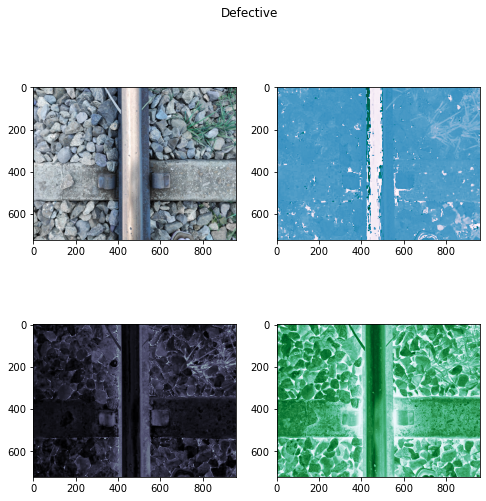

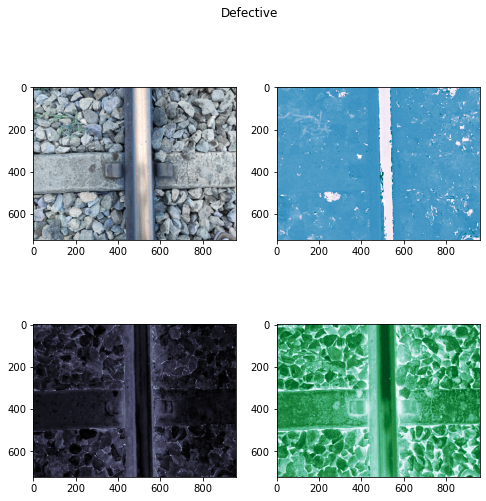

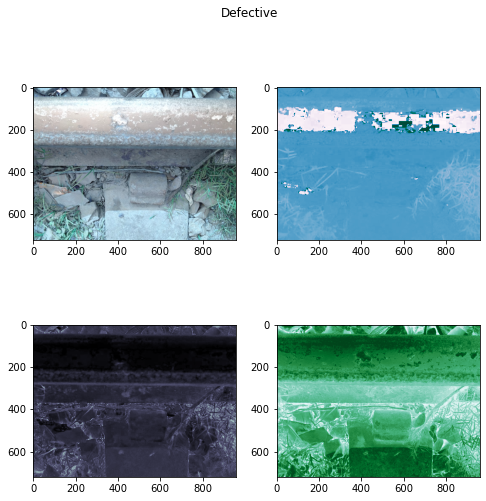

In [35]:
for path in defective['path'].head(4):
    image = cv.imread(path)
    hsv = color.rgb2hsv(image)
    dimension = hsv.shape
    fig = plt.figure(figsize=(8, 8))
    plt.suptitle("Defective")
    plt.subplot(2,2,1)
    plt.imshow(image)
    plt.subplot(2,2,2)
    plt.imshow(hsv[:dimension[0],:dimension[1],0], cmap="PuBuGn")
    plt.subplot(2,2,3)
    plt.imshow(hsv[:dimension[0],:dimension[1],1], cmap='bone')
    plt.subplot(2,2,4)
    plt.imshow(hsv[:dimension[0],:dimension[1],2], cmap='BuGn')
plt.show()

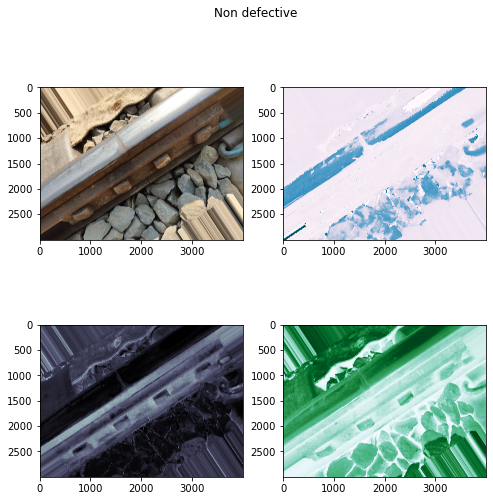

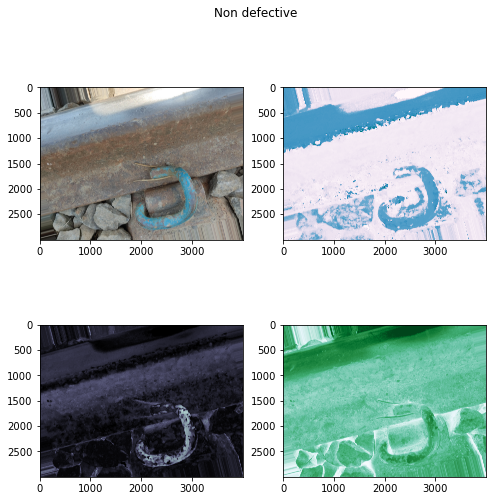

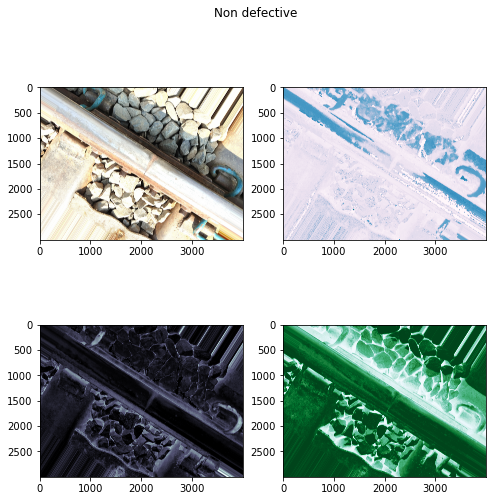

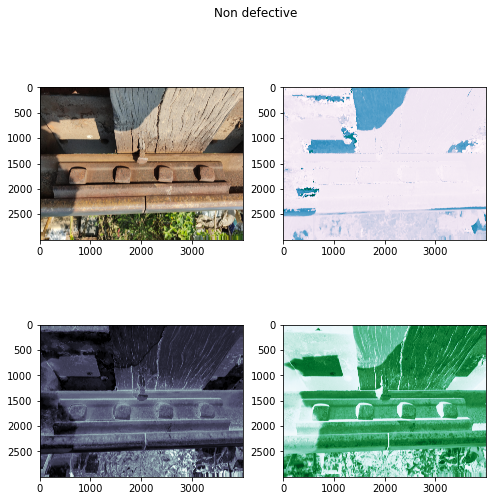

In [36]:
for path in undefective['path'].head(4):
    image = cv.imread(path)
    hsv = color.rgb2hsv(image)
    dimension = hsv.shape
    fig = plt.figure(figsize=(8, 8))
    plt.suptitle("Non defective")
    plt.subplot(2,2,1)
    plt.imshow(image)
    plt.subplot(2,2,2)
    plt.imshow(hsv[:dimension[0],:dimension[1],0], cmap="PuBuGn")
    plt.subplot(2,2,3)
    plt.imshow(hsv[:dimension[0],:dimension[1],1], cmap='bone')
    plt.subplot(2,2,4)
    plt.imshow(hsv[:dimension[0],:dimension[1],2], cmap='BuGn')
plt.show()

In [37]:
def get_dataset_partitions_tf(ds, train_split=0.9, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)    
    test_ds = ds.skip(train_size).take(test_size)
    
    
    return train_ds, test_ds

In [38]:
train_ds, test_ds = get_dataset_partitions_tf(train_ds)

In [39]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
def model(width , height):
    model = Sequential()
    model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=( width, height, 3)))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    
    model.add(Dense(25, activation='softmax'))
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer = 'adam', metrics=['accuracy'])
    return model

In [42]:
model=model(150 , 150)

In [43]:
model_fit = model.fit(train_ds, epochs=20 ,batch_size = batch_size ,validation_data=val_ds, verbose =1)

Epoch 1/20
27/27 [==============================] - 92s 2s/step - loss: 40.0919 - accuracy: 0.4002 - val_loss: 1.1959 - val_accuracy: 0.4893
Epoch 2/20
27/27 [==============================] - 20s 769ms/step - loss: 1.1568 - accuracy: 0.5751 - val_loss: 0.9834 - val_accuracy: 0.4786
Epoch 3/20
27/27 [==============================] - 20s 731ms/step - loss: 0.8757 - accuracy: 0.6772 - val_loss: 0.9105 - val_accuracy: 0.5036
Epoch 4/20
27/27 [==============================] - 20s 735ms/step - loss: 0.6216 - accuracy: 0.7582 - val_loss: 1.0088 - val_accuracy: 0.4964
Epoch 5/20
27/27 [==============================] - 20s 732ms/step - loss: 0.5146 - accuracy: 0.8228 - val_loss: 1.0402 - val_accuracy: 0.4893
Epoch 6/20
27/27 [==============================] - 20s 747ms/step - loss: 0.4285 - accuracy: 0.8451 - val_loss: 1.0643 - val_accuracy: 0.4964
Epoch 7/20
27/27 [==============================] - 22s 812ms/step - loss: 0.3104 - accuracy: 0.8908 - val_loss: 1.2372 - val_accuracy: 0.5107
E

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 30)      840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 15)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 36, 36, 15)        0         
                                                                 
 flatten (Flatten)           (None, 19440)             0

In [45]:
model.save("RAILWAY.h5")

first image to predict
actual label: Non Defective
1/1 [==============================] - 1s 1s/step
predicted label: Non Defective


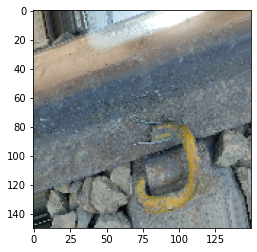

In [46]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 66ms/step


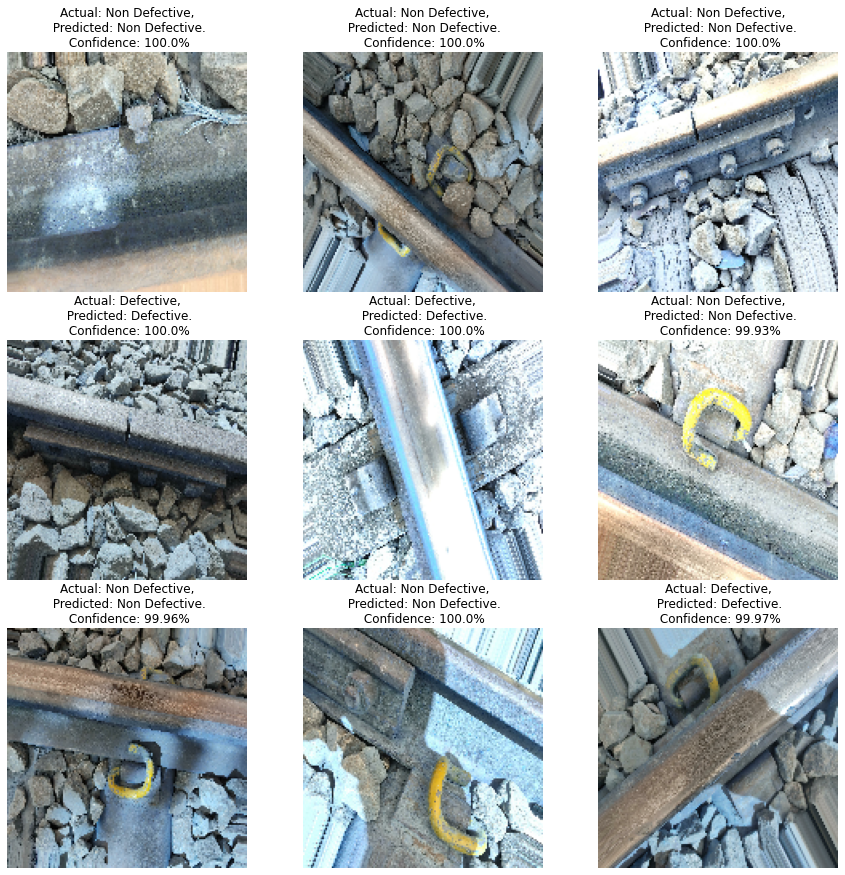

In [48]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [49]:
from keras.models import load_model
model=load_model("RAILWAY.h5")

In [50]:
from keras.preprocessing import image
import keras.utils as image
img_path="E:\\SELVA\\NEXON TECH\\PYTHON PROJECTS\\railway\\INPUT\\INPUT D5.jpg"
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)                   
img_tensor = np.expand_dims(img_tensor, axis=0)         
                                      
pred=model.predict(img_tensor)
print(class_names[np.argmax(pred)])

1/1 [==============================] - 0s 123ms/step
Defective
